<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/Santander-CT/Santander_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Santander Customer Transaction Prediction
Can you identify who will make a transaction?

## Data Description


You are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.

The task is to predict the value of target column in the test set.



##File descriptions


train.csv - the training set.

test.csv - the test set. The test set contains some rows which are not included in scoring.

sample_submission.csv - a sample submission file in the correct format.

## Setup

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py -O ml_functions.py
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py -O plot_functions.py
  ! pip install bayesian-optimization 
  ! pip install category-encoders
  ! pip install catboost
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c santander-customer-transaction-prediction
  ! unzip test.csv.zip  
  ! unzip train.csv.zip && unzip sample_submission.csv.zip

Saving kaggle.json to kaggle.json
--2021-08-08 13:14:08--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6651 (6.5K) [text/plain]
Saving to: ‘ml_functions.py’

ml_functions.py     100%[===================>]   6.50K  --.-KB/s    in 0s      

2021-08-08 13:14:09 (75.7 MB/s) - ‘ml_functions.py’ saved [6651/6651]

--2021-08-08 13:14:09--  https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

## Import Libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold,KFold
from scipy.stats import norm, skew


# Classifier Libraries
import lightgbm as lgb
import catboost as cgb
import xgboost as xgb
from bayes_opt import BayesianOptimization
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import collections
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

import ml_functions as ml
import plot_functions as plf

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")


In [ ]:
train.sample(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
92523,train_92523,0,12.5265,-9.2262,5.5134,5.8666,10.6807,-17.9380,5.2682,17.6538,0.3763,6.1671,2.7556,2.3127,14.0497,13.0618,11.1704,13.8106,9.5422,-11.1065,17.1041,19.0441,17.6654,20.5531,7.2118,2.4898,17.5026,13.7069,-13.1802,-3.2596,5.2708,5.8405,-21.4072,10.3734,-1.4467,17.3681,11.1503,-4.6203,1.9017,6.9517,...,26.6809,5.5353,3.6369,2.8497,5.9054,16.8882,2.7730,-18.5216,5.3433,5.8973,8.9261,3.2182,28.4993,0.7225,24.5445,8.2333,-1.3351,13.2764,5.7115,-1.0292,1.2865,13.6574,-16.1807,0.9246,28.0229,-8.3315,8.0039,-4.7701,13.0080,0.9238,-1.1540,3.0138,1.8080,-1.3706,14.0778,1.0777,4.9718,8.3805,13.7198,-7.0438
188496,train_188496,0,4.5159,-2.7109,8.2446,5.9783,11.4423,-7.2754,4.7520,17.1883,2.8143,7.0102,-3.1312,6.4775,14.2025,9.0497,4.8188,14.3099,10.6084,0.8942,11.2326,17.8917,10.8154,30.4734,4.4065,2.9838,8.0689,13.6086,-7.0049,0.1335,5.5471,2.8833,-9.6080,12.9599,0.8288,16.7676,11.6050,4.8978,-0.0960,6.2261,...,38.8499,5.8677,6.5106,8.7328,-9.9764,18.4781,2.8902,-13.6201,3.7699,5.6718,5.1294,-11.6588,21.6170,-6.5335,24.5488,9.2557,-3.2229,8.5465,-5.7628,-2.9209,0.9951,10.2683,-16.3230,10.4753,9.0193,-6.4387,6.9367,-4.5348,21.8540,-0.4044,13.0771,5.3070,3.0215,11.4519,21.1688,2.4963,-6.0732,8.9950,11.2021,-15.9625
164372,train_164372,0,13.4491,-0.0972,10.5087,10.1500,9.8306,-11.1623,5.3978,13.0132,6.5029,8.9145,0.0437,-6.5972,14.2892,6.4919,4.7639,14.7217,8.0237,-7.4429,22.8580,4.5346,20.3828,23.9765,1.7000,2.3584,15.4944,14.4223,0.4925,1.0142,6.8158,4.5333,-20.6410,12.3701,-1.4516,19.9604,11.9793,1.4627,-0.2731,7.4854,...,25.1762,5.6498,5.2340,4.5163,-12.6423,19.6672,2.9595,-4.2469,4.3554,5.4296,-6.5889,-4.4168,18.5011,5.3745,24.8980,15.0916,4.4927,10.2587,-7.9019,5.8684,2.8644,11.2151,9.7085,3.3951,34.5099,-1.9763,9.8960,8.0353,16.7109,0.4379,1.2675,5.5068,1.8742,-1.0282,20.1037,-0.2968,3.1737,8.4943,17.2708,-8.9308
142209,train_142209,0,7.7120,-1.4248,11.2356,4.3997,12.3380,5.5212,6.9334,12.4041,3.1080,7.6637,-1.8382,-12.8391,14.0427,1.7727,10.1555,14.3987,9.9512,-1.0327,7.1214,1.1131,17.3043,29.9468,3.7308,2.7431,8.6439,12.9183,-6.9314,-0.7477,5.3447,4.3253,-12.8266,11.3158,2.6413,14.1658,11.7885,5.7825,-0.5642,3.2999,...,29.8768,5.1945,4.4523,16.1692,-2.7989,18.2877,2.6840,-7.4385,8.0469,5.5239,1.6822,2.7814,13.1193,3.7831,27.0915,8.7676,-7.2548,12.8709,3.1132,5.8157,-5.6360,9.5145,5.0852,6.6586,9.3216,-10.3654,6.1516,-40.3318,11.2040,1.6751,6.6241,8.2514,2.8333,6.0664,14.4747,-3.2619,-2.2904,8.9822,15.8797,-9.7854
130583,train_130583,0,7.3997,-0.1874,9.2477,6.2690,14.1284,-16.0103,6.9138,18.8067,-0.1400,9.8066,10.0394,-2.8883,13.8818,11.7796,9.9306,13.9258,12.2000,-1.7013,9.1020,17.1986,9.0045,29.1466,6.4445,2.9753,6.7420,13.8747,2.0180,-3.0807,5.9440,5.0303,5.3294,10.7613,0.7432,15.6757,11.4215,9.0078,6.9157,3.7783,...,18.8226,5.1417,5.3494,0.8015,-11.8393,26.1318,2.7002,-1.0770,7.2008,5.7655,-3.7177,4.4531,18.8845,4.2775,25.6997,12.7767,-10.2289,6.6051,-8.9558,3.5687,-1.0741,11.4630,11.1366,8.1807,7.7540,-0.2889,12.1293,-16.5976,8.4426,1.1471,-0.2744,6.8021,2.2126,6.8501,21.3350,-0.7293,4.5858,8.1090,11.1890,-11.9463


In [ ]:
a = train[train["target"]==0]['target'].value_counts()
b = train[train["target"]==1]['target'].value_counts()
values = [a.values[0],b.values[0]]
labels = ["0","1"]

No transaction 179902
Transaction 20098




<BarContainer object of 2 artists>

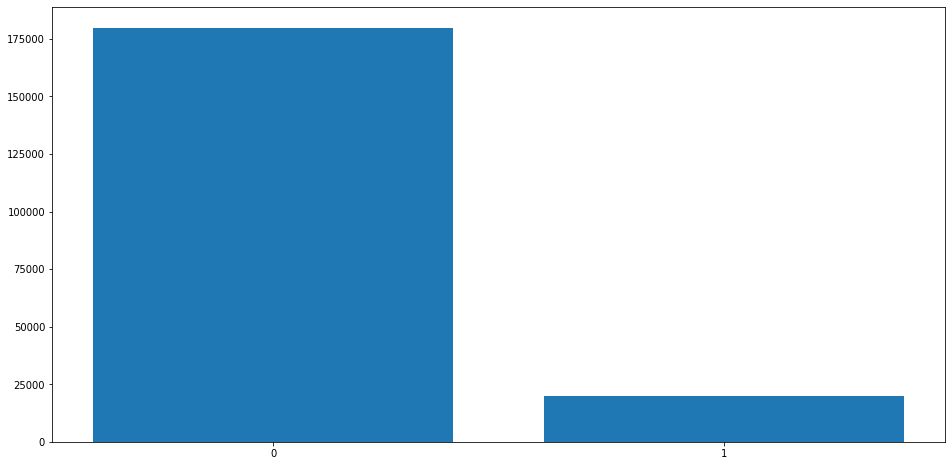

In [ ]:
# some plots
print('No transaction', train['target'].value_counts()[0])
print('Transaction', train['target'].value_counts()[1])
print("\n")

plt.figure(figsize=(16,8))
plt.bar(labels,values)


In [ ]:
print("the percentege of true is %.2f and the percentege of false is %.2f " % (100*(values[1]/len(train)),100*(values[0]/len(train))))


the percentege of true is 10.05 and the percentege of false is 89.95 


In [ ]:
len(train)

200000

The data is unbalanced

In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [ ]:
train.isnull().sum() # check null values


ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

## Exploratory data analysis

In [ ]:
features = train.columns.values
features[1:50]

array(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12',
       'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18',
       'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24',
       'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30',
       'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36',
       'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42',
       'var_43', 'var_44', 'var_45', 'var_46', 'var_47'], dtype=object)

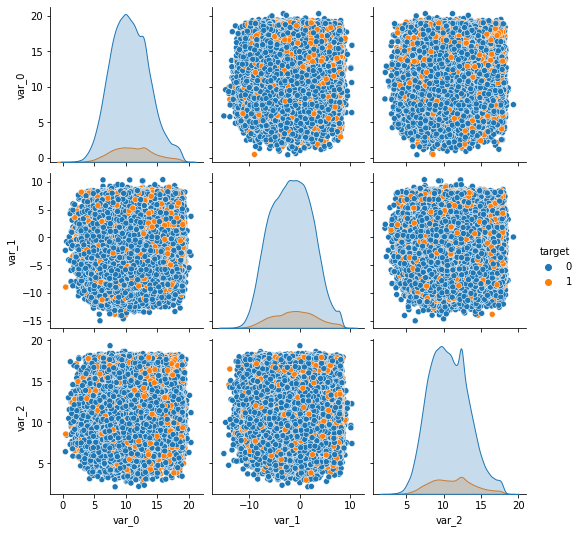

In [ ]:
sns.pairplot(train[features[0:5]],hue = 'target')

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

Text(0.5, 1.0, "Imbalanced Correlation Matrix \n (don't use for reference)")

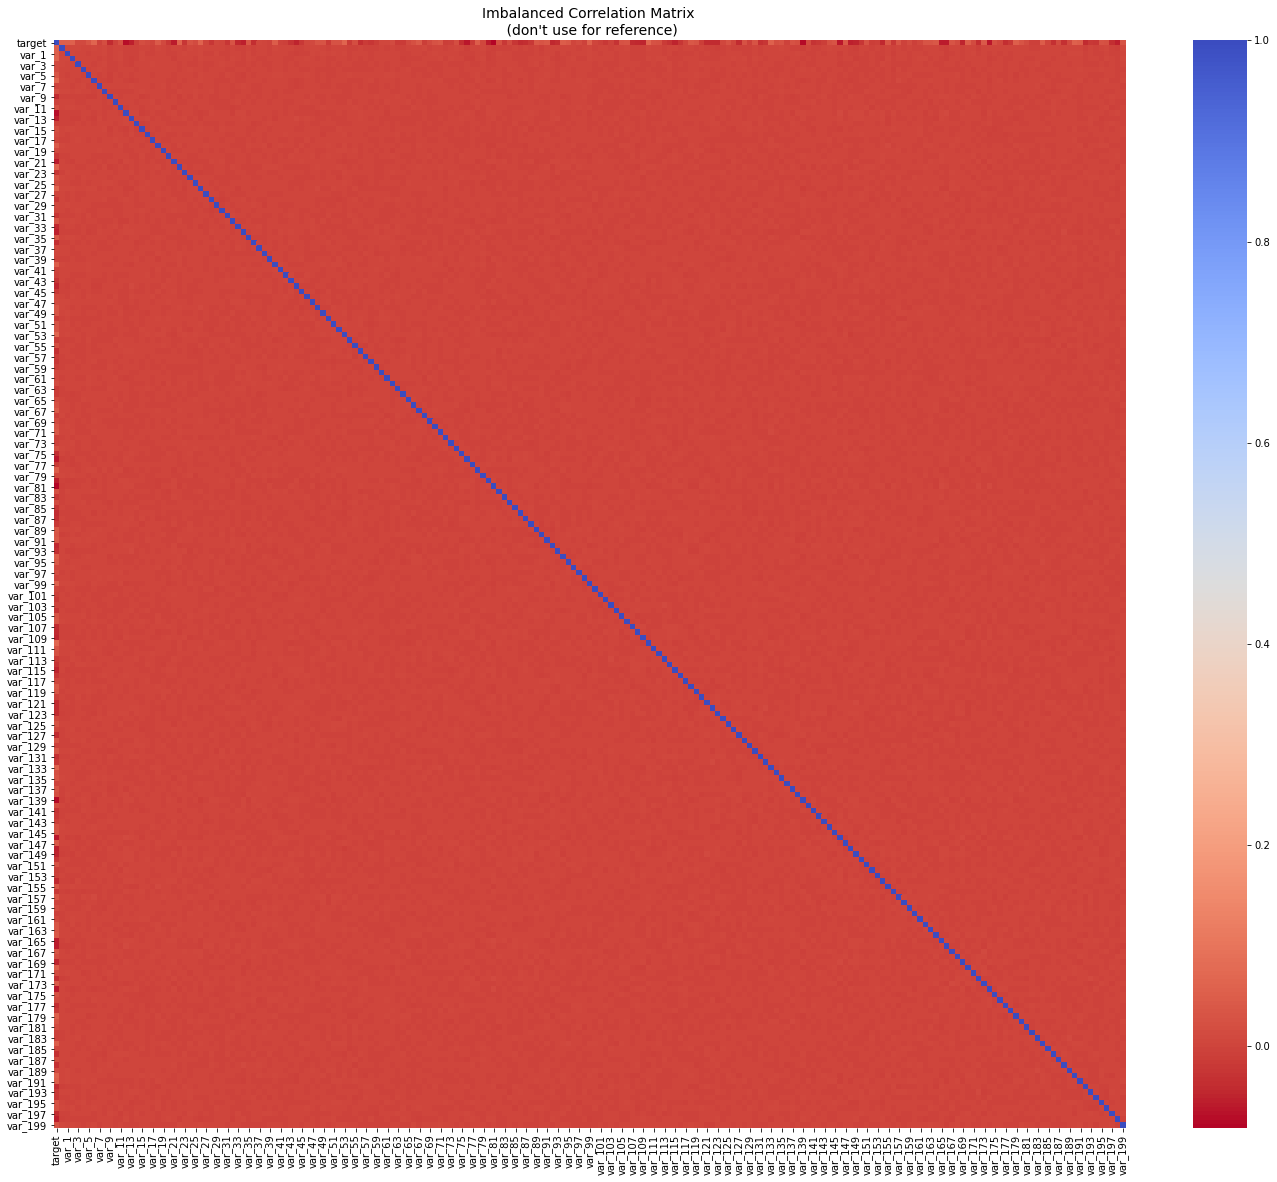

In [ ]:
# Make sure we use the subsample in our correlation

plt.figure(figsize=(24,20))

# Entire DataFrame
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


###Distribution of mean and std

Let's check the distribution of the mean values per row in the train and test set.

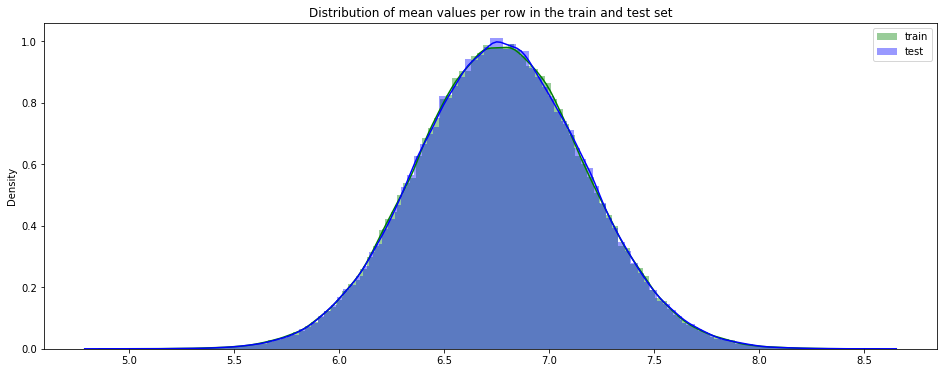

In [ ]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set.


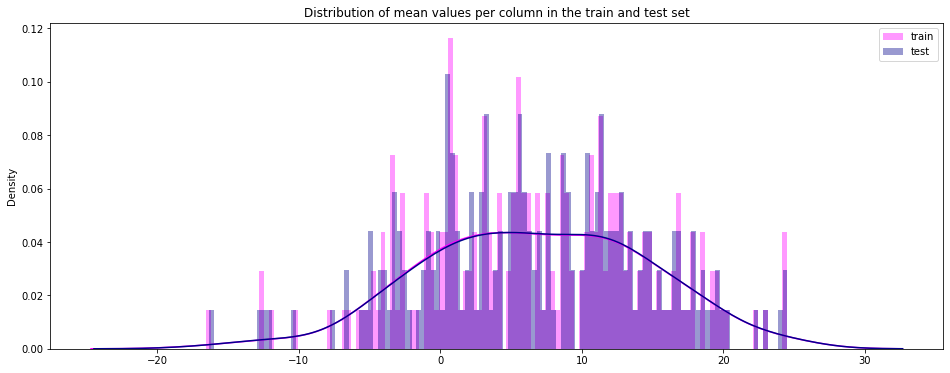

In [ ]:

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train.mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test.mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets.



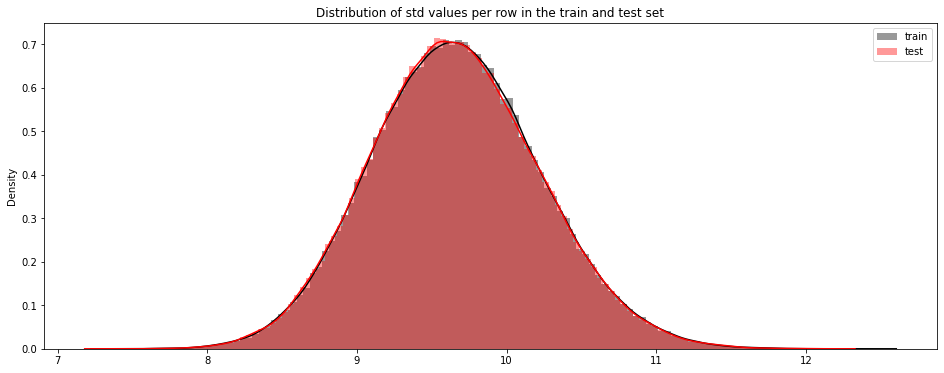

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.



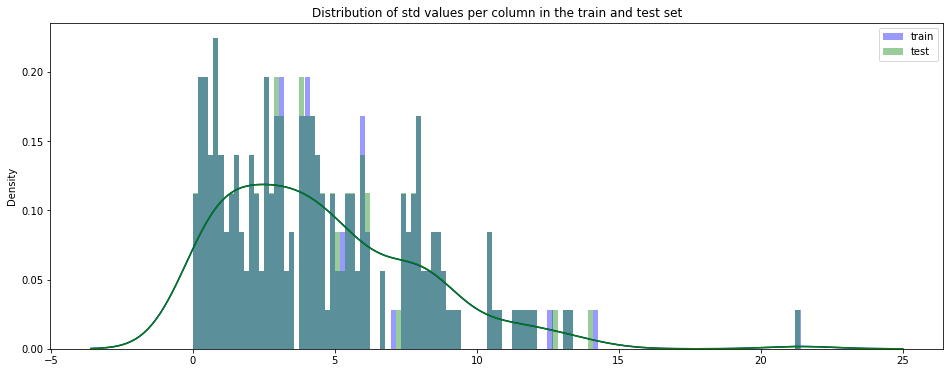

In [ ]:

plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.



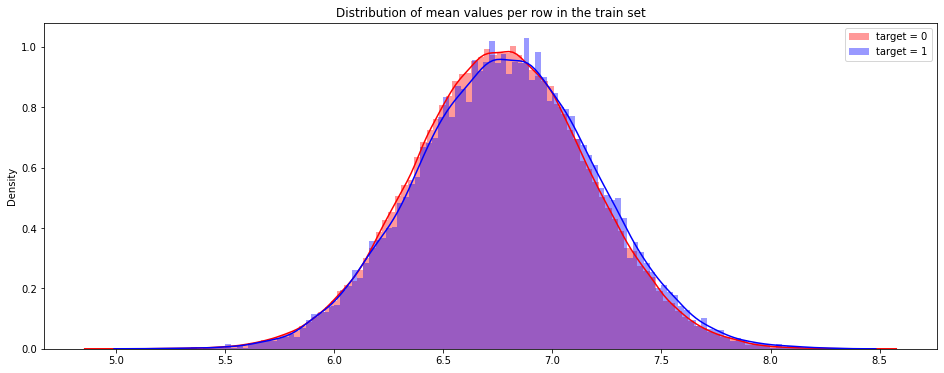

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()


Let's show now the distribution of max values per rown in the train set.



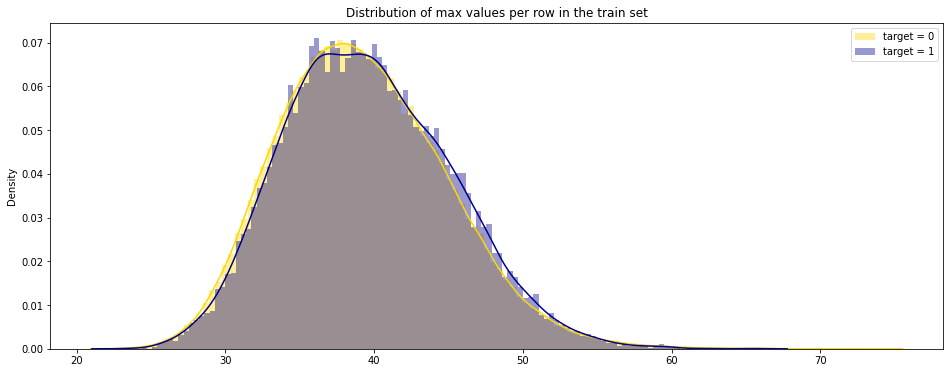

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.



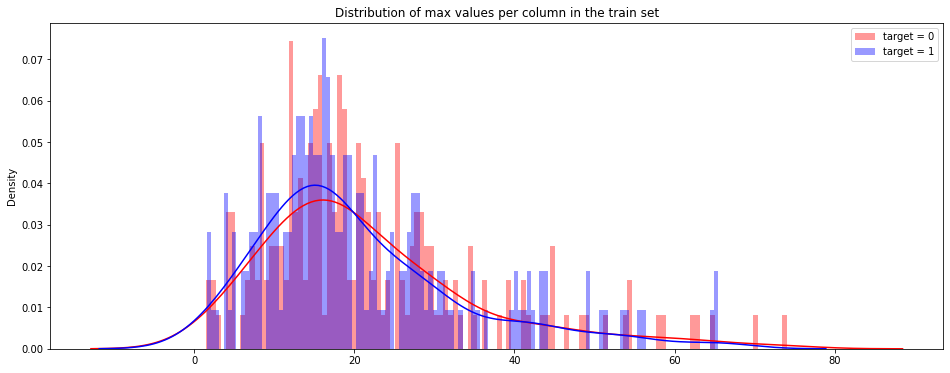

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Distribution of skew and kurtosis
Let's see now what is the distribution of skew values per rows and columns.

Let's see first the distribution of skewness calculated per rows in train and test sets.

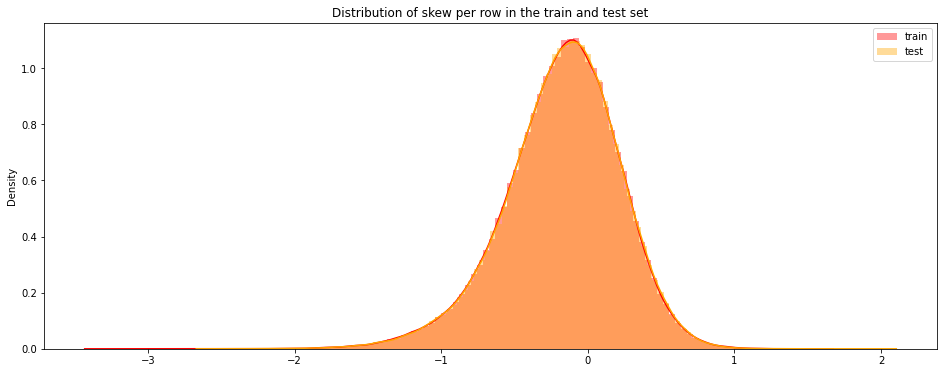

In [ ]:

plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see first the distribution of skewness calculated per columns in train and test set.



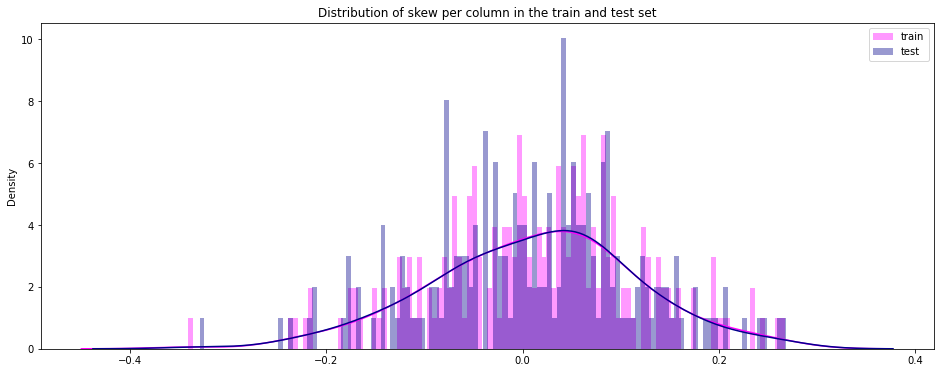

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### Correlations

In [ ]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)


,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


In [ ]:
correlations.tail(10)


,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


### Check duplicates values

In [ ]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
features = train.columns.values[2:]
unique_max_train = []
unique_max_test = []
for feature in features:
  values = train[feature].value_counts()
  unique_max_train.append([feature, values.max(), values.idxmax()])
  values = test[feature].value_counts()
  unique_max_test.append([feature, values.max(), values.idxmax()])


In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


and for the test set

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


### Feature Engineering

In [ ]:
idx = features = train.columns.values[2:]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [ ]:
train[train.columns[202:]].head()


,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [ ]:
test[test.columns[201:]].head()


,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

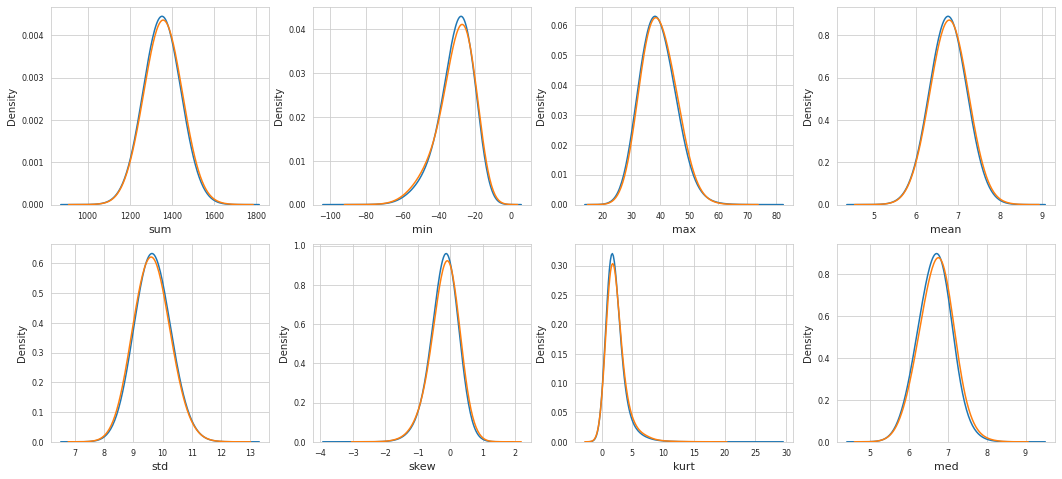

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 432x288 with 0 Axes>

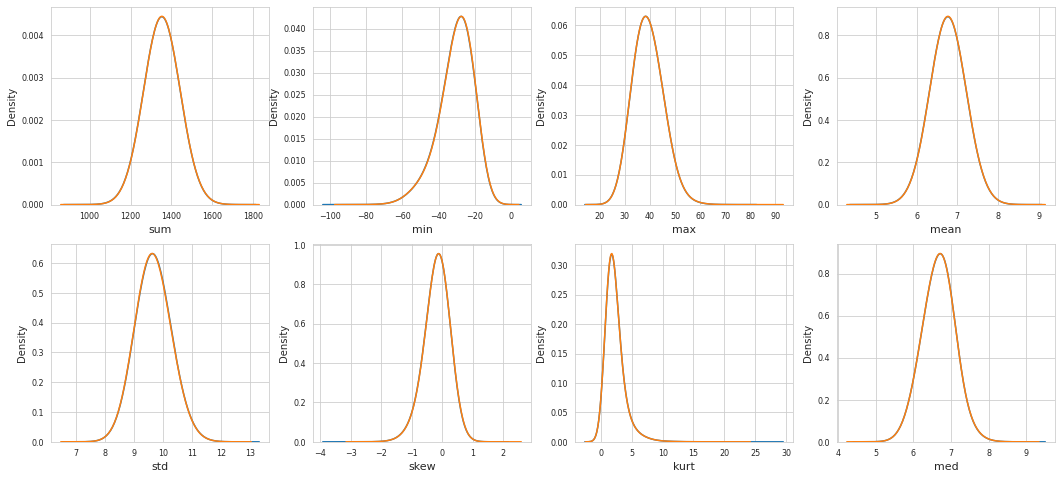

In [ ]:
features = train.columns.values[202:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

In [ ]:
orginal_train = train.copy()
orignal_test = test.copy()

In [ ]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
for feature in features:
    train['r2_'+feature] = np.round(train[feature], 2)
    test['r2_'+feature] = np.round(test[feature], 2)
    train['r1_'+feature] = np.round(train[feature], 1)
    test['r1_'+feature] = np.round(test[feature], 1)

In [ ]:
print('Train and test columns: {} {}'.format(len(orginal_train.columns), len(orignal_test.columns)))

Train and test columns: 210 209


In [ ]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 626 625


## Model

We will train using two datasets, one orinal and other with the features

### Orinal dataset

In [ ]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

### Tuning the Model

Here, we choose the LightGBM



In [ ]:
### LightGMB
dtrain = lgb.Dataset(data=orginal_train.drop(['ID_code', 'target'],axis = 1), label=orginal_train['target'])

def lgb_classifier(num_boost_round, num_leaves, max_depth, 
                   lambda_l2, lambda_l1, min_child_samples, 
                   min_data_in_leaf):
    params = {"boosting_type": 'gbdt',
              "objective" : "binary",
              "metric" : "auc", 
              "is_unbalance": True,
              "num_leaves" : int(num_leaves),
              "max_depth" : int(max_depth),
              "lambda_l2" : lambda_l2,
              "lambda_l1" : lambda_l1,
              "num_threads" : -1,
              "min_child_samples" : int(min_child_samples),
              "min_data_in_leaf": int(min_data_in_leaf),
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "verbosity" : -1,
              "num_boost_round": int(num_boost_round)}
    #train_data = lightgbm.Dataset(X_train, y_train, categorical_feature=categorical_features)
    cv_result = lgb.cv(params,
                       dtrain,
                       1000,
                       early_stopping_rounds=25,
                       stratified=True,
                       nfold=3)
    return cv_result['auc-mean'][-1]

In [ ]:
# Domain space-- Range of hyperparameters
pds = {'num_boost_round': (100, 500),
       'num_leaves': (25, 200),
       'max_depth': (5, 20),
       'lambda_l2': (0.0, 0.06),
       'lambda_l1': (0.0, 0.06),
       'min_child_samples': (50, 5000),
       'min_data_in_leaf': (100, 100)
      }

In [ ]:
#lgbBO = BayesianOptimization(lgb_classifier, pds)

#lgbBO.maximize(n_iter=5, init_points=2)

### Start the training

In [ ]:
#param = lgbBO.max['params']

In [ ]:
#param

In [ ]:
#for keys in param.keys():
#  param[keys] = int(param[keys])#


We had previsoly tunnig, then

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'lambda_l1' : 0.05585195015459345,
    'lambda_l2' : 0.04210753945460697
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
oof = np.zeros(len(train))
predictions_lgbm = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 300)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgbm += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 300 rounds.
[1000]	training's auc: 0.8854	valid_1's auc: 0.864005
[2000]	training's auc: 0.909445	valid_1's auc: 0.883624
[3000]	training's auc: 0.921107	valid_1's auc: 0.891679
[4000]	training's auc: 0.928564	valid_1's auc: 0.895779
[5000]	training's auc: 0.934203	valid_1's auc: 0.897754
[6000]	training's auc: 0.939047	valid_1's auc: 0.89873
[7000]	training's auc: 0.943529	valid_1's auc: 0.899223
[8000]	training's auc: 0.947723	valid_1's auc: 0.89951
Early stopping, best iteration is:
[7840]	training's auc: 0.947068	valid_1's auc: 0.899545
Fold 1
Training until validation scores don't improve for 300 rounds.
[1000]	training's auc: 0.885184	valid_1's auc: 0.86532
[2000]	training's auc: 0.909191	valid_1's auc: 0.884467
[3000]	training's auc: 0.920939	valid_1's auc: 0.892517
[4000]	training's auc: 0.928354	valid_1's auc: 0.896162
[5000]	training's auc: 0.933966	valid_1's auc: 0.89778
[6000]	training's auc: 0.938904	valid_1's auc: 

## CNN-Model

In [ ]:
from tensorflow import keras
use_experimental = False
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
oof = np.zeros(len(train))
predictions_cnn = np.zeros(len(test))


num_preds = 1
epochs = 50
learning_rate_init = 0.02
batch_size = 64
num_features = len(features)


def get_model():
    inp = keras.layers.Input((num_features*num_preds,))
    x = keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(24,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(4,1, activation='elu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Reshape((num_features*4,1))(x)
    x = keras.layers.AveragePooling1D(2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=out)


def lr_scheduler(epoch):
    if epoch <= epochs*0.8:
        return learning_rate_init
    else:
        return learning_rate_init * 0.1


In [ ]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))


    optimizer = keras.optimizers.Adam(lr = learning_rate_init, decay = 0.00001)
    model = get_model()
    callbacks = []
    callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train.iloc[trn_idx][features], target.iloc[trn_idx],validation_split = 0.2,batch_size = 128,epochs=epochs, callbacks=callbacks)
    oof[val_idx] = model.predict(train.iloc[val_idx][features])[:,0] 
    predictions_cnn += model.predict(test[features])[:,0] / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
Epoch 1/50
1125/1125 [==============================] - 25s 8ms/step - loss: 0.2699 - accuracy: 0.9038 - val_loss: 0.3259 - val_accuracy: 0.9037
Epoch 2/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2409 - accuracy: 0.9116 - val_loss: 9.6077 - val_accuracy: 0.1007
Epoch 3/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2411 - accuracy: 0.9112 - val_loss: 4.1990 - val_accuracy: 0.8992
Epoch 4/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2402 - accuracy: 0.9118 - val_loss: 23.1291 - val_accuracy: 0.1007
Epoch 5/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2400 - accuracy: 0.9116 - val_loss: 0.2595 - val_accuracy: 0.9123
Epoch 6/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2369 - accuracy: 0.9127 - val_loss: 0.5685 - val_accuracy: 0.7128
Epoch 7/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.2368 - accuracy: 0.9129 - val_loss: 0.2552 - val_

## Submission

In [ ]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions_cnn
sub_df.to_csv("submission.csv", index=False)

In [ ]:
! kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "CNN"

100% 5.94M/5.94M [00:02<00:00, 2.21MB/s]
Successfully submitted to Santander Customer Satisfaction